In [ ]:
#import jax and other libraries for computation
import jax.numpy as jnp
from jax import jit
from jax.scipy.signal import convolve2d
from jax.flatten_util import ravel_pytree
from jax.experimental.ode import odeint
from jax import tree_util
import jax.random as random
import numpy as np
#for visulization
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
# Set Palatino as the default font
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)
# import AdoptODE
from adoptODE import train_adoptODE, simple_simulation, dataset_adoptODE
#import the MSD mechanics
from HelperAndMechanics import *
import h5py

In [ ]:
# Load from HDF5
with h5py.File('../data/SpringMassModel/MechanicalData/data_eta_05_uvx.h5', 'r') as f:
    v = f['v'][:100]
    u = f['u'][:100]
    T = f['T'][:100]
    x = f['x'][:100]
    f.close()
print('max_v = ',np.max(v),'\nmax_u =',np.max(u),' \nmax_T = ',np.max(T))
N = T.shape[0]

NameError: name 'h5py' is not defined

In [ ]:
def define_MSD(**kwargs_sys):
    N_sys = kwargs_sys['N_sys']

    def gen_params():
        return {key:value + kwargs_sys['par_tol']*value*np.random.uniform(-1.0, 1.0) for key,value in kwargs_sys['params_true'].items()}, {}, {}
    
    def gen_y0():
        return {'u':kwargs_sys['u0'],'v':kwargs_sys['v0'],'T':kwargs_sys['T0'],'x':kwargs_sys['x0'],'x_dot':kwargs_sys['x_dot0']}
    @jit
    def kernel(spacing):
        kernel = np.array([[1, 4, 1], [4, -20.0, 4], [1, 4, 1]]) / (spacing* spacing * 6)
        return kernel
    @jit
    def laplace(f,params):  #laplace of scalar
        f_ext = jnp.concatenate((f[0:1], f, f[-1:]), axis=0)
        f_ext = jnp.concatenate((f_ext[:, 0:1], f_ext, f_ext[:, -1:]), axis=1)
        return convolve2d(f_ext, kernel(params['spacing']), mode='valid')
    @jit
    def epsilon(u,v,rp):
        return rp['epsilon_0']+rp['mu_1']*v/(u+rp['mu_2'])
    @jit
    def epsilon_T(u):
        return 1 - 0.9*jnp.exp(-jnp.exp(-30*(jnp.abs(u) - 0.1)))
    @jit
    def eom(y, t, params, iparams, exparams):
            
            par=params
            u=y['u']
            v=y['v']
            T=y['T']
            x=y['x']
            x_dot=y['x_dot']

            dudt = par['D']*laplace(u,par)-(par['k'])*u*(u-par['a'])*(u-1) - u*v
            dvdt = epsilon(u,v,par)*(-v-(par['k'])*u*(u-par['a']-1))
            dTdt = epsilon_T(u)*(par['k_T']*jnp.abs(u)-T)
            dx_dotdt = 1/par['m'] *  (force_field_active(x,T,par) + force_field_passive(x,par) + force_field_struct(x,T,par) - x_dot * par['c_damp'])
            dxdt = x_dot

            return {'u':dudt, 'v':dvdt, 'T':dTdt, 'x':zero_out_edges(dxdt), 'x_dot':zero_out_edges(dx_dotdt)}
    @jit
    def loss(ys, params, iparams, exparams, targets):
        # u = ys['u']
        # u_target = targets['u']
        pad = 10
        x = ys['x'][:,:,pad:-pad,pad:-pad]
        x_target = targets['x'][:,:,pad:-pad,pad:-pad]
        x_dot = ys['x_dot'][:,:,pad:-pad,pad:-pad]
        x_dot_target = targets['x_dot'][:,:,pad:-pad,pad:-pad]
        
        return  jnp.nanmean((x - x_target)**2 + (x_dot-x_dot_target)**2)#jnp.nanmean((u - u_target)**2) +
            
    return eom, loss, gen_params, gen_y0, {}

def define_MSD_rec(**kwargs_sys):
    N_sys = kwargs_sys['N_sys']

    def gen_params():
        return {key:value + kwargs_sys['par_tol']*value*np.random.uniform(-1.0, 1.0) for key,value in kwargs_sys['params_true'].items()}, {}, {}
    
    # def gen_y0():
    #     return {'u':kwargs_sys['u0'],'v':kwargs_sys['v0'],'T':kwargs_sys['T0'],'x':kwargs_sys['x0'],'x_dot':kwargs_sys['x_dot0']}
    @jit
    def kernel(spacing):
        kernel = np.array([[1, 4, 1], [4, -20.0, 4], [1, 4, 1]]) / (spacing* spacing * 6)
        return kernel
    @jit
    def laplace(f,params):  #laplace of scalar
        f_ext = jnp.concatenate((f[0:1], f, f[-1:]), axis=0)
        f_ext = jnp.concatenate((f_ext[:, 0:1], f_ext, f_ext[:, -1:]), axis=1)
        return convolve2d(f_ext, kernel(params['spacing']), mode='valid')
    @jit
    def epsilon(u,v,rp):
        return rp['epsilon_0']+rp['mu_1']*v/(u+rp['mu_2'])
    @jit
    def epsilon_T(u):
        return 1 - 0.9*jnp.exp(-jnp.exp(-30*(jnp.abs(u) - 0.1)))
    @jit
    def eom(y, t, params, iparams, exparams):
            
            par=params
            u=y['u']
            v=y['v']
            T=y['T']
            x=y['x']
            x_dot=y['x_dot']

            dudt = par['D']*laplace(u,par)-(par['k'])*u*(u-par['a'])*(u-1) - u*v
            dvdt = epsilon(u,v,par)*(-v-(par['k'])*u*(u-par['a']-1))
            dTdt = epsilon_T(u)*(par['k_T']*jnp.abs(u)-T)
            dx_dotdt = 1/par['m'] *  (force_field_active(x,T,par) + force_field_passive(x,par) + force_field_struct(x,T,par) - x_dot * par['c_damp'])
            dxdt = x_dot

            return {'u':dudt, 'v':dvdt, 'T':dTdt, 'x':zero_out_edges(dxdt), 'x_dot':zero_out_edges(dx_dotdt)}
    @jit
    def loss(ys, params, iparams, exparams, targets):
        pad = 10
        x = ys['x'][:,:,pad:-pad,pad:-pad]
        x_target = targets['x'][:,:,pad:-pad,pad:-pad]
        x_dot = ys['x_dot'][:,:,pad:-pad,pad:-pad]
        x_dot_target = targets['x_dot'][:,:,pad:-pad,pad:-pad]
        u_target = targets['u']
        u = ys['u']
        return  jnp.nanmean((x - x_target)**2 + (x_dot-x_dot_target)**2)#+ jnp.nanmean((u - u_target)**2)
            
    return eom, loss, gen_params, None, {}

In [ ]:
def get_ini_sim(u,v,T,x,x_dot,sim_indx,size = 100,pad = 10,delta_t_e = 0.08,sampling_rate = 10,length = 30):
    '''gets the initial conditions for the simulation
    if sim_indx=0 then the initial conditions are taken from raw data
    if sim_indx=1 then the initial conditions are taken from the last state of the recent simulation'''
    t_evals = np.linspace(0, delta_t_e*sampling_rate*length, length)
    if sim_indx == 0:
        #define grid and initial conditions
        u_fit = u[:length*sampling_rate][::sampling_rate,:,:]
        T_fit = T[:length*sampling_rate][::sampling_rate,:,:]
        v_fit = v[:length*sampling_rate][::sampling_rate,:,:]
        x_fit = x[:length*sampling_rate][::sampling_rate,:,:,:]
        x_dot = np.gradient(x,axis = 0)/delta_t_e
        x_dot_fit = x_dot[:length*sampling_rate][::sampling_rate,:,:,:]
        #select input state
        u0 = u_fit[0]
        v0 = v_fit[0]
        T0 = T_fit[0]
        x0 = x_fit[0]
        x_dot0 = x_dot_fit[0]
    else:
        u0 = u[-1]
        v0 = v[-1]
        T0 = T[-1]
        x0 = x[-1]
        x_dot0 = x_dot[-1]
        
    return u0, v0, T0, x0, x_dot0, t_evals

def get_ini_fit(u_sol,v_sol,T_sol,x,x_dot,sim_indx,size = 100,pad = 10,delta_t_e = 0.08,sampling_rate = 10,length=30):
    '''gets the initial conditions for the simulation
    if sim_indx=0 then u,v,T are initialized as resting stante (0)
    if sim_indx=1 then the u,v,T are taken from the last state of the recent fit'''
    t_evals = np.linspace(0, delta_t_e*sampling_rate*length, length)
    if sim_indx == 0:
        #select input state
        # dA = np.abs(compute_dA(x, 1)[:,pad:-pad,pad:-pad])
        u0 = jnp.full((1,length,100,100),.5)#dA[0]/np.max(dA[0])*np.max(u)
        v0 = jnp.full((1,length,100,100),0. )#dA[0]/np.max(dA[0])*np.max(v)
        T0 = jnp.full((1,length,100,100),0.)#dA[0]/np.max(dA[0])*np.max(T)
        # x0 = x[0]
        # x_dot0 = x_dot[0]
    else:
        u0 = u_sol[-1]
        u0 = np.broadcast_to(u0, (length, 100, 100))
        v0 = v_sol[-1]
        v0 = np.broadcast_to(v0, (length, 100, 100))
        T0 = T_sol[-1]
        T0 = np.broadcast_to(T0, (length, 100, 100))
        # x0 = x[:,-1]
        # x_dot0 = x_dot[:,-1]
    print(u0.shape,v0.shape,T0.shape,x.shape,x_dot.shape)
    return u0, v0, T0, x, x_dot, t_evals


In [ ]:
"""
    Reads in necessary parameters from config.ini
"""
N,size,params = read_config(['D','a','k','epsilon_0','mu_1','mu_2','k_T','delta_t_e'
                             ,'k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp',
                             'n_0','l_0','spacing'],mode = 'chaos')

keys =['D','a','k','epsilon_0','mu_1','mu_2','k_T','delta_t_e'
        ,'k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp',
        'n_0','l_0','spacing']
tol = 0
params_true = dict(zip(keys,params))
params_low = {key: value - value*tol for key, value in params_true.items()}
params_high = {key: value + value*tol for key, value in params_true.items()}
x_dot = np.gradient(x, axis=0) / params_true['delta_t_e']
length,sampling_rate = 10,20
pad = 10
u0,v0,T0,x0,x_dot0,t_evals = get_ini_sim(u,v,T,x,x_dot,0,sampling_rate=sampling_rate,length=length)

kwargs_sys = {'size': 100,
              'spacing': 1,
              'N_sys': 1,
              'par_tol': 0,
              'params_true': params_true,
              'u0': u0,'v0': v0,'T0': T0,'x0': x0,'x_dot0': x_dot0}
kwargs_adoptODE = {'epochs': 10,'N_backups': 1,'lr': 1e-3,'lower_b': params_low,'upper_b': params_high,
                   'lower_b_y0':{'u':u0,'v':v0,'T':T0,'x':x0,'x_dot':x_dot0},
                    'upper_b_y0':{'u':u0,'v':v0,'T':T0,'x':x0,'x_dot':x_dot0}}

In [ ]:
grad_u = np.gradient(u,axis=0)[0]/np.max(np.gradient(u,axis=0)[0])
u_stencil = (1- u[0])*2
dA = compute_dA(x, 1)[:,pad:-pad,pad:-pad]


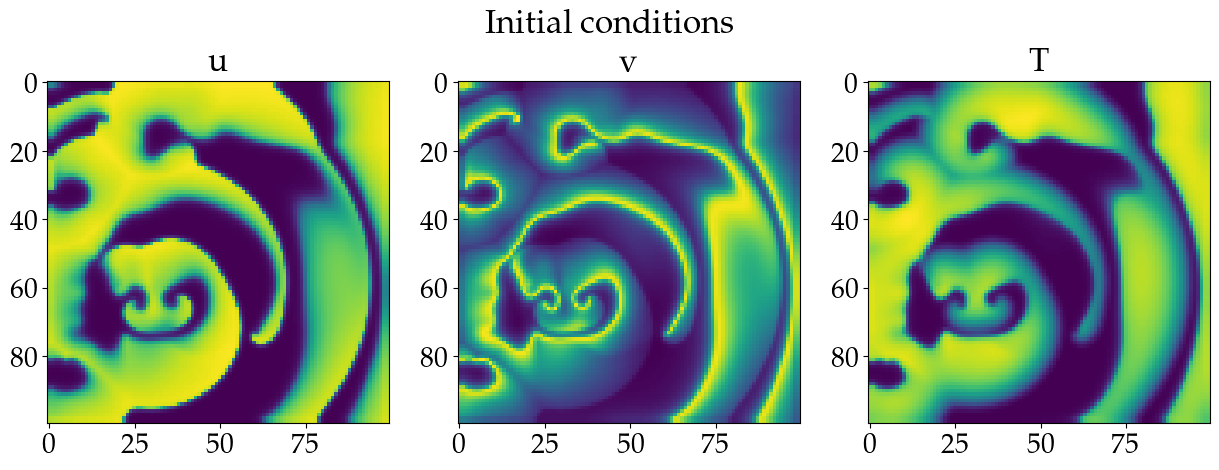

In [ ]:
#make 3 subplots for u,v,T
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Initial conditions')
axs[0].imshow(u[0], cmap='viridis')
axs[0].set_title('u')
axs[1].imshow(v[0], cmap='viridis')
axs[1].set_title('v')
axs[2].imshow(T[0], cmap='viridis')
axs[2].set_title('T')

plt.show()

In [ ]:
# Setting up a dataset via simulation
Simulation_MSD = simple_simulation(define_MSD,
                            t_evals,
                            kwargs_sys,
                            kwargs_adoptODE)

In [ ]:
with h5py.File('../data/SpringMassModel/EtaSweep/FullDomain_len10lr20.h5', 'r') as f:
    u_sol_cluster = f['u_sol'][0]
    u_cluster = f['u'][0]
    params_train = f["params_train"].attrs  # Access the attributes of the group
    extracted_params = {key: params_train[key] for key in params_train}
    f.close()

In [ ]:
print('Parameter:   True Value:   Recovered Value:')
for key in params_true.keys():
    print(key+(16-len(key))*' '+'{:.3f}         {:-3f}'.format(params_true[key], extracted_params[key]),'rel err',np.abs(params_true[key]-extracted_params[key])/params_true[key])

Parameter:   True Value:   Recovered Value:
D               0.220         0.023656 rel err 0.89247257
a               0.050         0.031477 rel err 0.3704602
k               8.000         5.887384 rel err 0.26407695
epsilon_0       0.002         0.001406 rel err 0.29688945
mu_1            0.200         0.380000 rel err 0.9
mu_2            0.300         0.409249 rel err 0.36416292
k_T             3.000         3.110496 rel err 0.036832094
delta_t_e       0.080         0.037516 rel err 0.5310452
k_ij            13.000         11.741032 rel err 0.09684372
k_ij_pad        23.000         23.000000 rel err 0.0
k_j             2.000         1.600628 rel err 0.19968599
k_a             9.000         12.033650 rel err 0.33707225
k_a_pad         23.000         23.000000 rel err 0.0
c_a             10.000         8.795033 rel err 0.12049665
m               1.000         0.468735 rel err 0.5312652
c_damp          15.000         24.045948 rel err 0.6030632
n_0             0.500         0.518371 rel

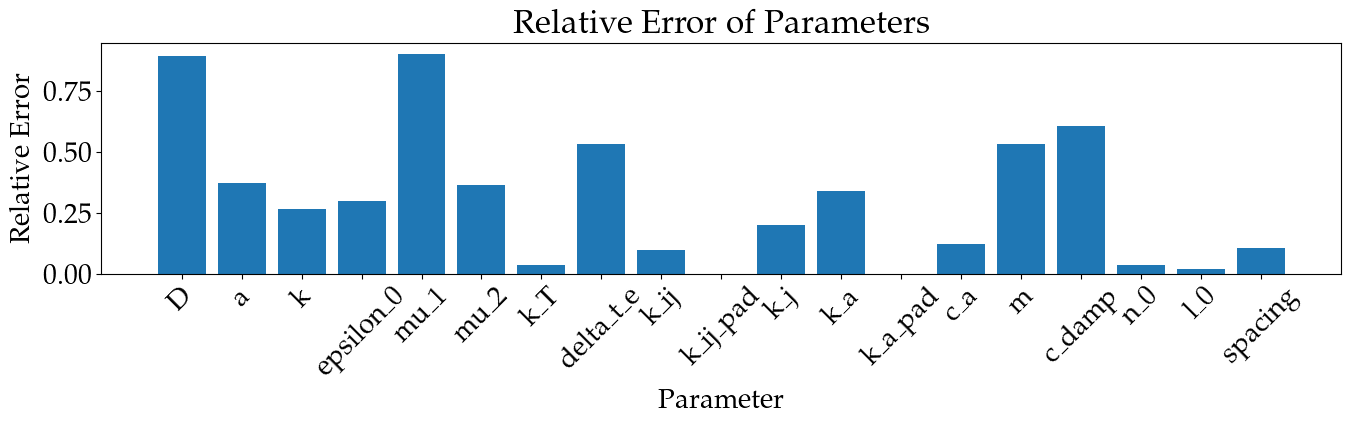

In [ ]:
# Get the parameter names
param_names = list(params_true.keys())
# Calculate the relative error for each parameter
relative_errors = []

for param_name in param_names:
    
    real_value = params_true.get(param_name, np.nan)
    train_value = extracted_params.get(param_name, np.nan)
    if np.isnan(real_value) or np.isnan(train_value):
        relative_errors.append(np.nan)
    else:
        relative_error = np.abs((train_value - real_value) / real_value)
        relative_errors.append(relative_error)
# Plot the relative errors
plt.figure(figsize=(16, 3))
plt.bar(param_names, relative_errors)
plt.xlabel('Parameter')
plt.ylabel('Relative Error')
plt.title('Relative Error of Parameters')
plt.xticks(rotation=45)
plt.show()

In [ ]:
u_sol = Simulation_MSD.ys['u'][0]
vmin,vmax =  0,1
pad = 10
# Function to update the plot
u_err = np.abs(u_sol - u_sol_cluster)
def update_plot(frame):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # Create 2 side-by-side subplots
    
    # Plot dA_fit
    im1 = axes[0].matshow(u_sol_cluster[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im1 = axes[0].matshow(dA_rec[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"Reconstruction")
    
    # Plot dA_sim
    im2 = axes[1].matshow(u_sol[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im2 = axes[1].matshow(dA_sim[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"Simulation")
    
    # Add colorbars
    fig.colorbar(im1, ax=axes[0])
    fig.colorbar(im2, ax=axes[1])

    plt.show()
def update_single_plot(frame):
    fig,axes = plt.subplots(1, 1, figsize=(10,8))

    # Plot dA_fit
    im1 = axes.matshow(u_err[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im1 = axes.matshow(dA_err[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes.set_title(f"$u_e$")

    # Add colorbars
    fig.colorbar(im1, ax=axes)

    plt.show()


# Create interactive slider
frame_slider = widgets.IntSlider(min=0, max=u_sol_cluster.shape[0]-1, step=1, value=0, description="Frame")

# Use interactive_output instead of interactive
out = widgets.interactive_output(update_plot, {'frame': frame_slider})

# Display slider and output
display(frame_slider, out)

IntSlider(value=0, description='Frame', max=9)

Output()

## Find largest Lyapunov exponent

In [ ]:
def compute_log_div(data):
    """
    Compute the largest Lyapunov exponent from reaction-diffusion system data.
    
    Parameters:
    data (numpy.ndarray): 3D array of shape (t, 100, 100), where t is time.
    
    Returns:
    float: Estimated largest Lyapunov exponent (lambda_max).
    """
    t, x, y = data.shape  # Extract dimensions
    states = data.reshape(t, -1)  # Flatten spatial dimensions
    
    # Compute Euclidean distances between consecutive states
    distances = np.linalg.norm(states[1:] - states[:-1], axis=1)
    
    # Avoid division by zero
    if distances[0] == 0:
        raise ValueError("Initial distance is zero; choose different initial conditions.")
    
    # Compute log divergence over time
    log_divergence = np.log(distances / distances[0])
    
    return log_divergence  # Largest Lyapunov exponent

data = u  # Simulated chaotic data

log_divergence= compute_log_div(data)


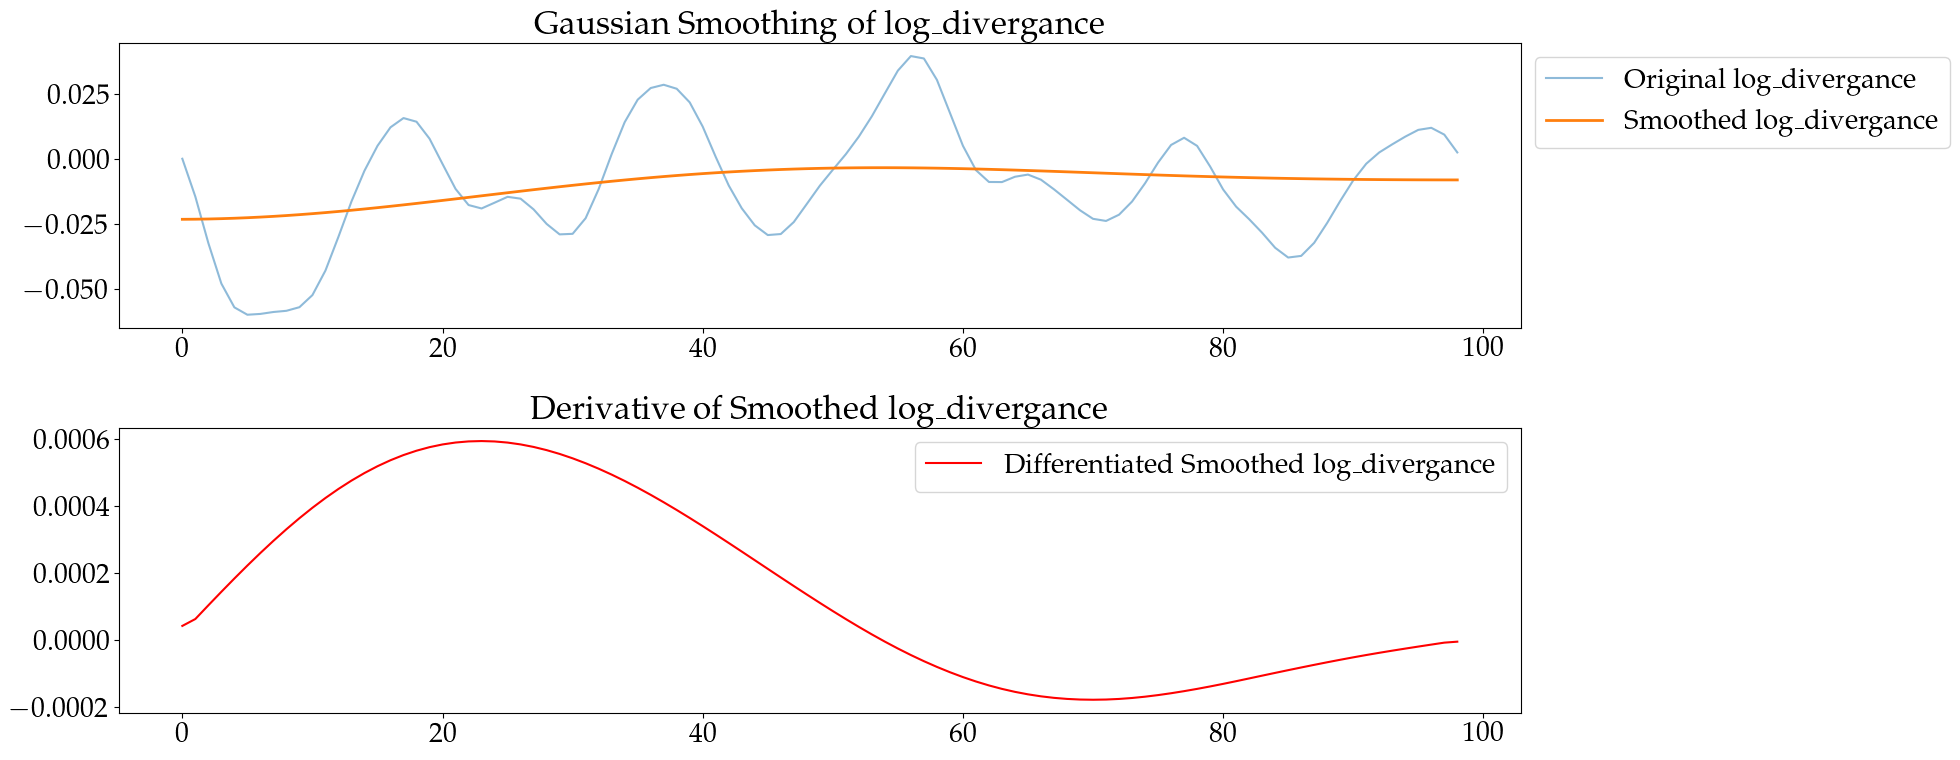

Largest Lyapunov exponent: 1681.756679991965


In [ ]:

# Apply Gaussian smoothing
sigma = 20  # Adjust sigma for more or less smoothing
smoothed_data = gaussian_filter1d(log_divergence, sigma)

# Differentiate the smoothed data
differentiated_data = np.gradient(smoothed_data)

# Plot results
plt.figure(figsize=(20, 8))

# Original and Smoothed Data
plt.subplot(2, 1, 1)
plt.plot( log_divergence, label='Original log_divergance', alpha=0.5)
plt.plot( smoothed_data, label='Smoothed log_divergance', linewidth=2)
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Gaussian Smoothing of log_divergance')

# Differentiated Data
plt.subplot(2, 1, 2)
plt.plot( differentiated_data, label='Differentiated Smoothed log_divergance', color='red')
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Derivative of Smoothed log_divergance')

plt.tight_layout()
plt.show()
print('Largest Lyapunov exponent:', 1/max(differentiated_data))

## Use Simulation data as ground trouth

In [ ]:
fit_indx = 0
pad = 10
tol = .5
params_low = {key: value - value*tol for key, value in params_true.items()}
params_high = {key: value + value*tol for key, value in params_true.items()}
params_high['k_ij_pad'],params_low['k_ij_pad'] = params_true['k_ij_pad']  ,params_true['k_ij_pad']
params_high['k_a_pad'],params_low['k_a_pad'] = params_true['k_a_pad']  ,params_true['k_a_pad']

In [ ]:
u0,v0,T0,x0,x_dot0,t_evals = get_ini_fit(Simulation_MSD.ys['u'],Simulation_MSD.ys['v'],
                                        Simulation_MSD.ys['T'], Simulation_MSD.ys['x'], Simulation_MSD.ys['x_dot'],
                                        fit_indx,length=length,sampling_rate=sampling_rate)

targets = {'u':u0,'v':v0,'T':T0,'x':x0,'x_dot':x_dot0}
kwargs_sys = {'size': 100,
            'N_sys': 1,
            'par_tol': tol,
            'params_true': params_true}
kwargs_adoptODE = {'epochs': 50,'N_backups': 1,'lr': 2e-3,'lower_b': params_low,'upper_b': params_high,
                'lr_y0':2e-3,
                'lower_b_y0':{'u':0.,'v':0.,'T':0.,'x':x0,'x_dot':x_dot0},
                'upper_b_y0':{'u':np.max(u),'v':np.max(v),'T':np.max(T),'x':x0,'x_dot':x_dot0}}

(1, 10, 100, 100) (1, 10, 100, 100) (1, 10, 100, 100) (1, 10, 2, 121, 121) (1, 10, 2, 121, 121)


In [ ]:
# targets = {'u':jnp.full((Simulation_MSD.ys['u'].shape),.5),'v': jnp.zeros_like(Simulation_MSD.ys['v']),'T':jnp.zeros_like(Simulation_MSD.ys['T']),
#            'x':Simulation_MSD.ys['x'],'x_dot':Simulation_MSD.ys['x_dot']}
# kwargs_sys = {'size': 100,
#               'N_sys': 1,
#               'par_tol': tol,
#               'params_true': params_true,
#               'u0': u0,'v0': v0,'T0': T0,'x0': x0,'x_dot0': x_dot0}
# kwargs_adoptODE = {'epochs': 100,'N_backups': 1,'lr': 3e-2,'lower_b': params_low,'upper_b': params_high,
#                    'lr_y0':3e-2,
#                    'lower_b_y0':{'u':0,'v':0,'T':0,'x':x0,'x_dot':x_dot0},
#                     'upper_b_y0':{'u':1,'v':np.max(u),'T':np.max(T),'x':x0,'x_dot':x_dot0}}
dataset_MSD = dataset_adoptODE(define_MSD_rec,
                                targets,
                                t_evals, 
                                kwargs_sys,
                                kwargs_adoptODE,
                                true_params=params_true)

In [ ]:
params_final, losses, errors, params_history = train_adoptODE(dataset_MSD, print_interval=10, save_interval=10)
print('Found params: ', dataset_MSD.params_train)

Epoch 000:  Loss: 1.0e-02,  Params Err.: 1.5e+01, y0 error: nan, Params Norm: 4.4e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 


Exception: Gradients resulted to nans. Maybe try the back_check function to see is your backward pass is instable. In that case it can help to increase the number of Backups ('N_backups') used in between time points.

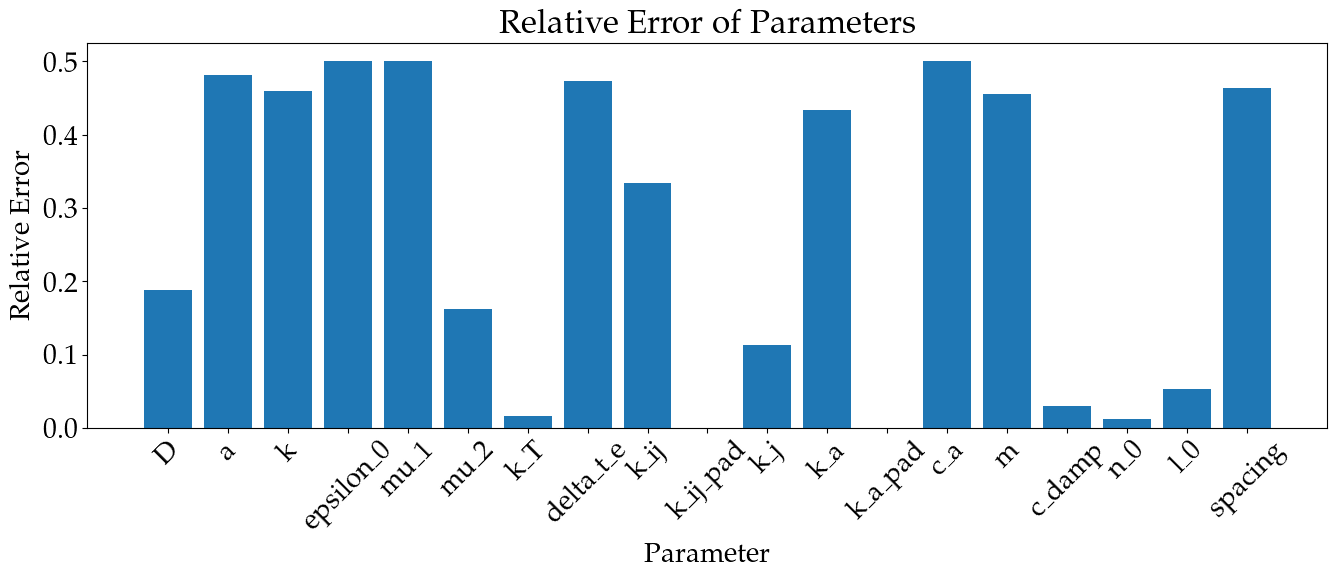

0.4941496


In [ ]:
# Get the parameter names
param_names = list(params_true.keys())
# Calculate the relative error for each parameter
relative_errors = []

for param_name in param_names:
    
    real_value = params_true.get(param_name, np.nan)
    train_value = dataset_MSD.params_train.get(param_name, np.nan)
    if np.isnan(real_value) or np.isnan(train_value):
        relative_errors.append(np.nan)
    else:
        relative_error = np.abs((train_value - real_value) / real_value)
        relative_errors.append(relative_error)
# Plot the relative errors
plt.figure(figsize=(16, 5))
plt.bar(param_names, relative_errors)
plt.xlabel('Parameter')
plt.ylabel('Relative Error')
plt.title('Relative Error of Parameters')
plt.xticks(rotation=45)
plt.show()
print(dataset_MSD.params_train['n_0'])

In [ ]:
x_rec = dataset_MSD.ys_sol['x'][0]
x_dot_rec = dataset_MSD.ys_sol['x_dot'][0]
T_rec = dataset_MSD.ys_sol['T'][0]
u_rec = dataset_MSD.ys_sol['u'][0]
v_rec = dataset_MSD.ys_sol['v'][0]

In [ ]:
dA_rec = compute_dA(x_rec, 1)
dA_sim = compute_dA(x_sim, 1)
u_err = u_rec - u_sim
u_sim = dataset_MSD.ys['u'][0]
dA_err = dA_sim - dA_rec 
vmin,vmax =  -.2,.2
pad = 10
# Function to update the plot
def update_plot(frame):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # Create 2 side-by-side subplots
    
    # Plot dA_fit
    im1 = axes[0].matshow(T_rec[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im1 = axes[0].matshow(dA_rec[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"reconstruction")
    
    # Plot dA_sim
    im2 = axes[1].matshow(T_sim[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im2 = axes[1].matshow(dA_sim[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"simulation")
    
    # Add colorbars
    fig.colorbar(im1, ax=axes[0])
    fig.colorbar(im2, ax=axes[1])

    plt.show()
def update_single_plot(frame):
    fig,axes = plt.subplots(1, 1, figsize=(10,8))

    # Plot dA_fit
    im1 = axes.matshow(u_err[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im1 = axes.matshow(dA_err[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes.set_title(f"dA error")

    # Add colorbars
    fig.colorbar(im1, ax=axes)

    plt.show()


# Create interactive slider
frame_slider = widgets.IntSlider(min=0, max=x_sim.shape[0]-1, step=1, value=0, description="Frame")

# Use interactive_output instead of interactive
out = widgets.interactive_output(update_plot, {'frame': frame_slider})

# Display slider and output
display(frame_slider, out)

IntSlider(value=0, description='Frame', max=9)

Output()